In [1]:
%matplotlib inline

In [2]:
from pandas import *
import numpy
import heapq
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from typing import Dict, List, Tuple, Optional, Iterator

In [3]:
# --- 1. Definitioner för A* (Typer och PriorityQueue) ---
# Vi definierar en Location som ett (x, y) par
GridLocation = Tuple[int, int]

class PriorityQueue:
    def __init__(self):
        self.elements: List[Tuple[float, GridLocation]] = []
    
    def empty(self) -> bool:
        return not self.elements
    
    def put(self, item: GridLocation, priority: float):
        heapq.heappush(self.elements, (priority, item))
    
    def get(self) -> GridLocation:
        return heapq.heappop(self.elements)[1]

In [4]:
#--- 2. Din Graph-klass (Bryggan) ---
class MazeGraph:
    def __init__(self, matrix):
        self.matrix = matrix
        self.height, self.width = matrix.shape

    # Detta krävs av din A*-funktion
    def cost(self, from_node: GridLocation, to_node: GridLocation) -> float:
        return 1

    # Detta krävs av din A*-funktion
    def neighbors(self, id: GridLocation) -> Iterator[GridLocation]:
        (x, y) = id
        # Lista alla möjliga riktningar (Höger, Vänster, Ner, Upp)
        results = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
        
        # Filtrera resultaten
        valid_neighbors = []
        for nx, ny in results:
            # Kolla så vi är innanför kartan
            if 0 <= nx < self.width and 0 <= ny < self.height:
                # Kolla så det inte är en vägg (0 = väg, 1 = vägg)
                if self.matrix[ny][nx] == 0:
                    valid_neighbors.append((nx, ny))
        return valid_neighbors

In [5]:
# --- 3. Din A* Kod (Oförändrad logik) ---
def heuristic(a: GridLocation, b: GridLocation) -> float:
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)

def a_star_search(graph: MazeGraph, start: GridLocation, goal: GridLocation):
    frontier = PriorityQueue()
    frontier.put(start, 0)
    came_from: Dict[GridLocation, Optional[GridLocation]] = {}
    cost_so_far: Dict[GridLocation, float] = {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():
        current: GridLocation = frontier.get()
        
        if current == goal:
            break
        
        for next in graph.neighbors(current):
            new_cost = cost_so_far[current] + graph.cost(current, next)
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + heuristic(next, goal)
                frontier.put(next, priority)
                came_from[next] = current
    
    return came_from, cost_so_far

In [6]:
#--- 4. Hjälpfunktion för att bygga stigen ---
def reconstruct_path(came_from: Dict[GridLocation, GridLocation], start: GridLocation, goal: GridLocation):
    current = goal
    path = []
    if goal not in came_from: # Om ingen väg hittades
        return []
        
    while current != start:
        path.append(current)
        current = came_from[current]
    path.append(start)
    path.reverse() # Vänd så vi får start -> mål
    return path

In [7]:
def make_maze(w , h):
    vis = [[0] * w + [1] for _ in range(h)] + [[1] * (w + 1)]
    ver = [["10"] * w + ['1'] for _ in range(h)] + [[]]
    hor = [["11"] * w + ['1'] for _ in range(h + 1)]
 
    def walk(x, y):
        vis[y][x] = 1
 
        d = [(x - 1, y), (x, y + 1), (x + 1, y), (x, y - 1)]
        shuffle(d)
        for (xx, yy) in d:
            if vis[yy][xx]: continue
            if xx == x: hor[max(y, yy)][x] = "10"
            if yy == y: ver[y][max(x, xx)] = "00"
            walk(xx, yy)
 
    walk(numpy.random.randint(w), numpy.random.randint(h))
 
    s = ""
    for (a, b) in zip(hor, ver):
        s += ''.join(a + ['\n'] + b + ['\n'])
        
    M=[]
    for line in s.split("\n"):
        if line!="":
            R=[]
            for e in line:
                R.append(int(e))
            M.append(R)
    return M

In [25]:
# --- 6. Huvudprogram ---

# Skapa labyrinten
maze_data = np.array(make_maze(8, 8))



In [26]:
# Hitta en giltig start och slutpunkt (där det är 0)
# Vi letar efter första lediga rutan uppe till vänster och nere till höger
height, width = maze_data.shape
start = (1, 1) # Oftast ledigt i denna generering
goal = (15, 15) # Oftast ledigt

# Dubbelkolla så vi inte startar i en vägg
if maze_data[start[1]][start[0]] == 1:
    # Sök efter första lediga om (1,1) är upptagen
    found = False
    for y in range(height):
        for x in range(width):
            if maze_data[y][x] == 0:
                start = (x, y)
                found = True
                break
        if found: break

# Skapa Graf-objektet
graph = MazeGraph(maze_data)

# Kör A*
came_from, cost_so_far = a_star_search(graph, start, goal)

# Få fram stigen
path = reconstruct_path(came_from, start, goal)

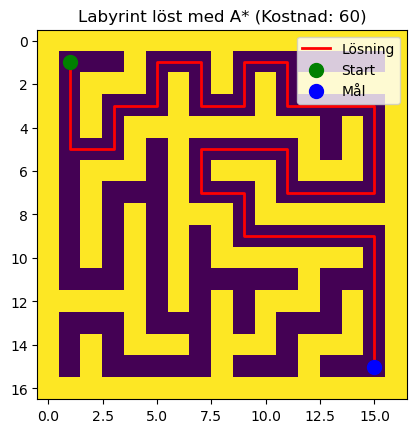

In [27]:
# --- 7. Visualisering ---
plt.imshow(maze_data)

# Extrahera x och y koordinater från stigen för att plotta
if path:
    path_x = [p[0] for p in path]
    path_y = [p[1] for p in path]
    plt.plot(path_x, path_y, color='red', linewidth=2, label='Lösning')
    plt.scatter([start[0]], [start[1]], color='green', s=100, label='Start', zorder=5)
    plt.scatter([goal[0]], [goal[1]], color='blue', s=100, label='Mål', zorder=5)
    plt.legend()
else:
    print("Ingen väg hittades!")

plt.title(f"Labyrint löst med A* (Kostnad: {cost_so_far.get(goal, 'Inf')})")
plt.show()